
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [1]:
#!pip install d2l==1.0.0-beta0



# Kaggle の犬種識別 (ImageNet Dogs)

このセクションでは、Kaggle で犬種識別問題を練習します。 (**このコンテストのウェブアドレスは https://www.kaggle.com/c/dog-breed-identification です**)

このコンテストでは、120 種類の犬が表彰されます。実際、このコンテストのデータセットは ImageNet データセットのサブセットです。 :numref: `sec_kaggle_cifar10`の CIFAR-10 データセット内の画像とは異なり、ImageNet データセット内の画像は、さまざまな寸法で高さと幅の両方が異なります。 :numref: `fig_kaggle_dog`コンテストの Web ページの情報を表示します。結果を送信するには Kaggle アカウントが必要です。 

![](../img/kaggle-dog.jpg) :幅: `400px` :ラベル: `fig_kaggle_dog`


In [2]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


## データセットの取得と整理

競争データセットはトレーニング セットとテスト セットに分割されており、それぞれ 3 つの RGB (カラー) チャネルの 10222 枚と 10357 枚の JPEG 画像が含まれています。トレーニング データセットには、ラブラドール、プードル、ダックスフント、サモエド、ハスキー、チワワ、ヨークシャー テリアなどの 120 品種の犬が含まれています。

### データセットのダウンロード

Kaggle にログインした後、:numref: `fig_kaggle_dog`に示されているコンペティション Web ページの [データ] タブをクリックし、[すべてダウンロード] ボタンをクリックしてデータセットをダウンロードできます。ダウンロードしたファイルを`../data`に解凍すると、データセット全体が次のパスに見つかります。
-  ../data/犬種識別/labels.csv
-  ../data/犬種識別/sample_submission.csv
-  ../data/犬種識別/train
-  ../data/犬種識別/テスト

お気づきかもしれませんが、上記の構造は :numref: `sec_kaggle_cifar10`の CIFAR-10 コンテストの構造と似ており、フォルダー`train/`と`test/`にはそれぞれトレーニング用の犬の画像とテスト用の犬の画像が含まれ、 `labels.csv`はトレーニング用のラベルが含まれています。画像。同様に、簡単に開始できるように、前述の [**データセットの小さなサンプルを提供しています**] `train_valid_test_tiny.zip` 。 Kaggle コンテストに完全なデータセットを使用する場合は、以下の`demo`変数を`False`に変更する必要があります。


In [3]:
#@save
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to `False`
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')


### [**データセットの整理**]

 :numref: `sec_kaggle_cifar10`で行ったことと同様にデータセットを整理できます。つまり、元のトレーニング セットから検証セットを分割し、画像をラベルごとにグループ化されたサブフォルダーに移動します。

以下の`reorg_dog_data`関数は、トレーニング データ ラベルを読み取り、検証セットを分割し、トレーニング セットを編成します。


In [4]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)


## [**画像拡張**]

この犬種データセットは ImageNet データセットのサブセットであり、その画像は :numref: `sec_kaggle_cifar10`の CIFAR-10 データセットの画像よりも大きいことを思い出してください。以下に、比較的大きな画像に役立ついくつかの画像拡張操作をリストします。


In [5]:
transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])


予測中は、ランダム性を持たずに画像の前処理操作のみを使用します。


In [6]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])


## [**データセットの読み取り**]

 :numref: `sec_kaggle_cifar10`と同様に、生の画像ファイルで構成される整理されたデータセットを読み取ることができます。


In [7]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]


以下では、 :numref: `sec_kaggle_cifar10`と同じ方法でデータ反復子のインスタンスを作成します。


In [8]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)


## [**事前学習済みモデルの微調整**]

繰り返しますが、このコンテストのデータセットは ImageNet データセットのサブセットです。したがって、:numref: `sec_fine_tuning`で説明したアプローチを使用して、完全な ImageNet データセットで事前トレーニングされたモデルを選択し、それを使用して画像特徴を抽出し、カスタムの小規模出力ネットワークに供給できます。深層学習フレームワークの高レベル API は、ImageNet データセットで事前トレーニングされた幅広いモデルを提供します。ここでは、事前トレーニング済みの ResNet-34 モデルを選択し、このモデルの出力層の入力 (つまり、抽出された特徴) を単純に再利用します。次に、元の出力層を、完全に接続された 2 つの層を積み重ねるなど、トレーニング可能な小さなカスタム出力ネットワークに置き換えることができます。 :numref: `sec_fine_tuning`の実験とは異なり、以下では特徴抽出に使用される事前学習済みモデルを再学習しません。これにより、トレーニング時間と勾配を保存するためのメモリが削減されます。

完全な ImageNet データセットの 3 つの RGB チャネルの平均と標準偏差を使用して画像を標準化したことを思い出してください。実際、これは ImageNet 上の事前学習済みモデルによる標準化操作とも一致します。


In [9]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # Move the model to devices
    finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net


[**損失を計算する**]前に、まず事前学習済みモデルの出力層の入力、つまり抽出された特徴を取得します。次に、この特徴を小さなカスタム出力ネットワークの入力として使用して、損失を計算します。


In [10]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n


## [**トレーニング関数**] の定義

モデルを選択し、検証セットでのモデルのパフォーマンスに応じてハイパーパラメーターを調整します。モデル トレーニング関数`train`小規模なカスタム出力ネットワークのパラメーターのみを反復します。


In [11]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')


## [**モデルのトレーニングと検証**]

これで、モデルをトレーニングして検証できるようになりました。次のハイパーパラメータはすべて調整可能です。たとえば、エポックの数を増やすことができます。 `lr_period`と`lr_decay`はそれぞれ 2 と 0.9 に設定されているため、最適化アルゴリズムの学習率は 2 エポックごとに 0.9 倍になります。


train loss 1.046, valid loss 1.336
897.7 examples/sec on [device(type='cuda', index=0)]


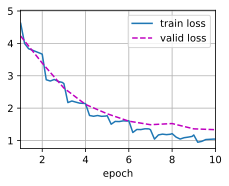

In [12]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)


## [**テストセットの分類**] と Kaggle への結果の送信

:numref: `sec_kaggle_cifar10`の最後のステップと同様に、最終的にはすべてのラベル付きデータ (検証セットを含む) がモデルのトレーニングとテスト セットの分類に使用されます。分類にはトレーニング済みのカスタム出力ネットワークを使用します。


train loss 1.175
908.2 examples/sec on [device(type='cuda', index=0)]


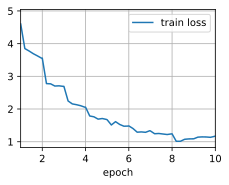

In [13]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')


上記のコードは、 :numref: `sec_kaggle_house`で説明されているのと同じ方法で Kaggle に送信される`submission.csv`ファイルを生成します。

## まとめ
- ImageNet データセット内の画像は、CIFAR-10 画像よりも大きくなります (さまざまな寸法)。別のデータセット上のタスクの画像拡張操作を変更する場合があります。
-  ImageNet データセットのサブセットを分類するには、完全な ImageNet データセットで事前トレーニングされたモデルを利用して特徴を抽出し、カスタムの小規模出力ネットワークのみをトレーニングできます。これにより、計算時間とメモリ コストの削減につながります。

## 演習
1. Kaggle の完全な競合データセットを使用する場合、他のハイパーパラメーターを`lr = 0.01` 、 `lr_period = 10` 、および`lr_decay = 0.1`に設定しながら、 `batch_size` (バッチ サイズ) と`num_epochs` (エポック数) を増やすと、どのような結果が得られますか?
1. より深く事前トレーニングされたモデルを使用すると、より良い結果が得られますか?ハイパーパラメータはどのように調整しますか?結果をさらに向上させることはできますか?



[ディスカッション](https://discuss.d2l.ai/t/1481)
